This project is written to create a complete system that detects faces from a camera, tracks emotion changes, saves the image when an emotion change occurs, and identifies the emotion using a machine learning model trained on the FER2013 dataset.

# Second version with weights. Activation ELU, CNN model.¶

### Step 1: Intsall requrements libraries, modelues and etc.

In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
import glob


from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Input
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.models import load_model


import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
# print("TensorFlow версии:", tf.__version__)

### Step 2: Load and Preprocess the FER2013 Dataset

In [ ]:
# the link for loading data set https://www.kaggle.com/datasets/ashishpatel26/facial-expression-recognitionferchallenge/data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
file_path = '/content/drive/MyDrive/diploma/data/fer2013.csv'
df = pd.read_csv(file_path)
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


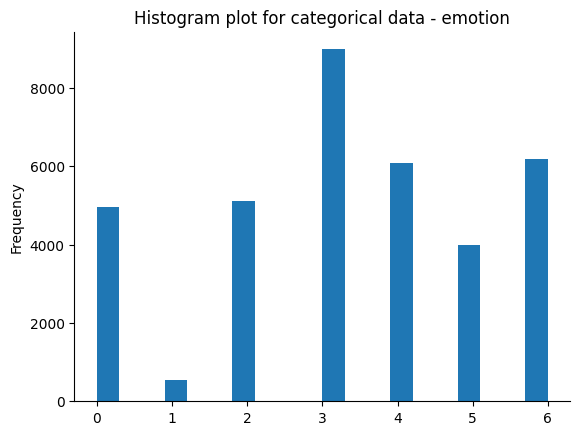

In [ ]:
df['emotion'].plot(kind='hist', bins=20, title='Histogram plot for categorical data - emotion')
pyplot.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

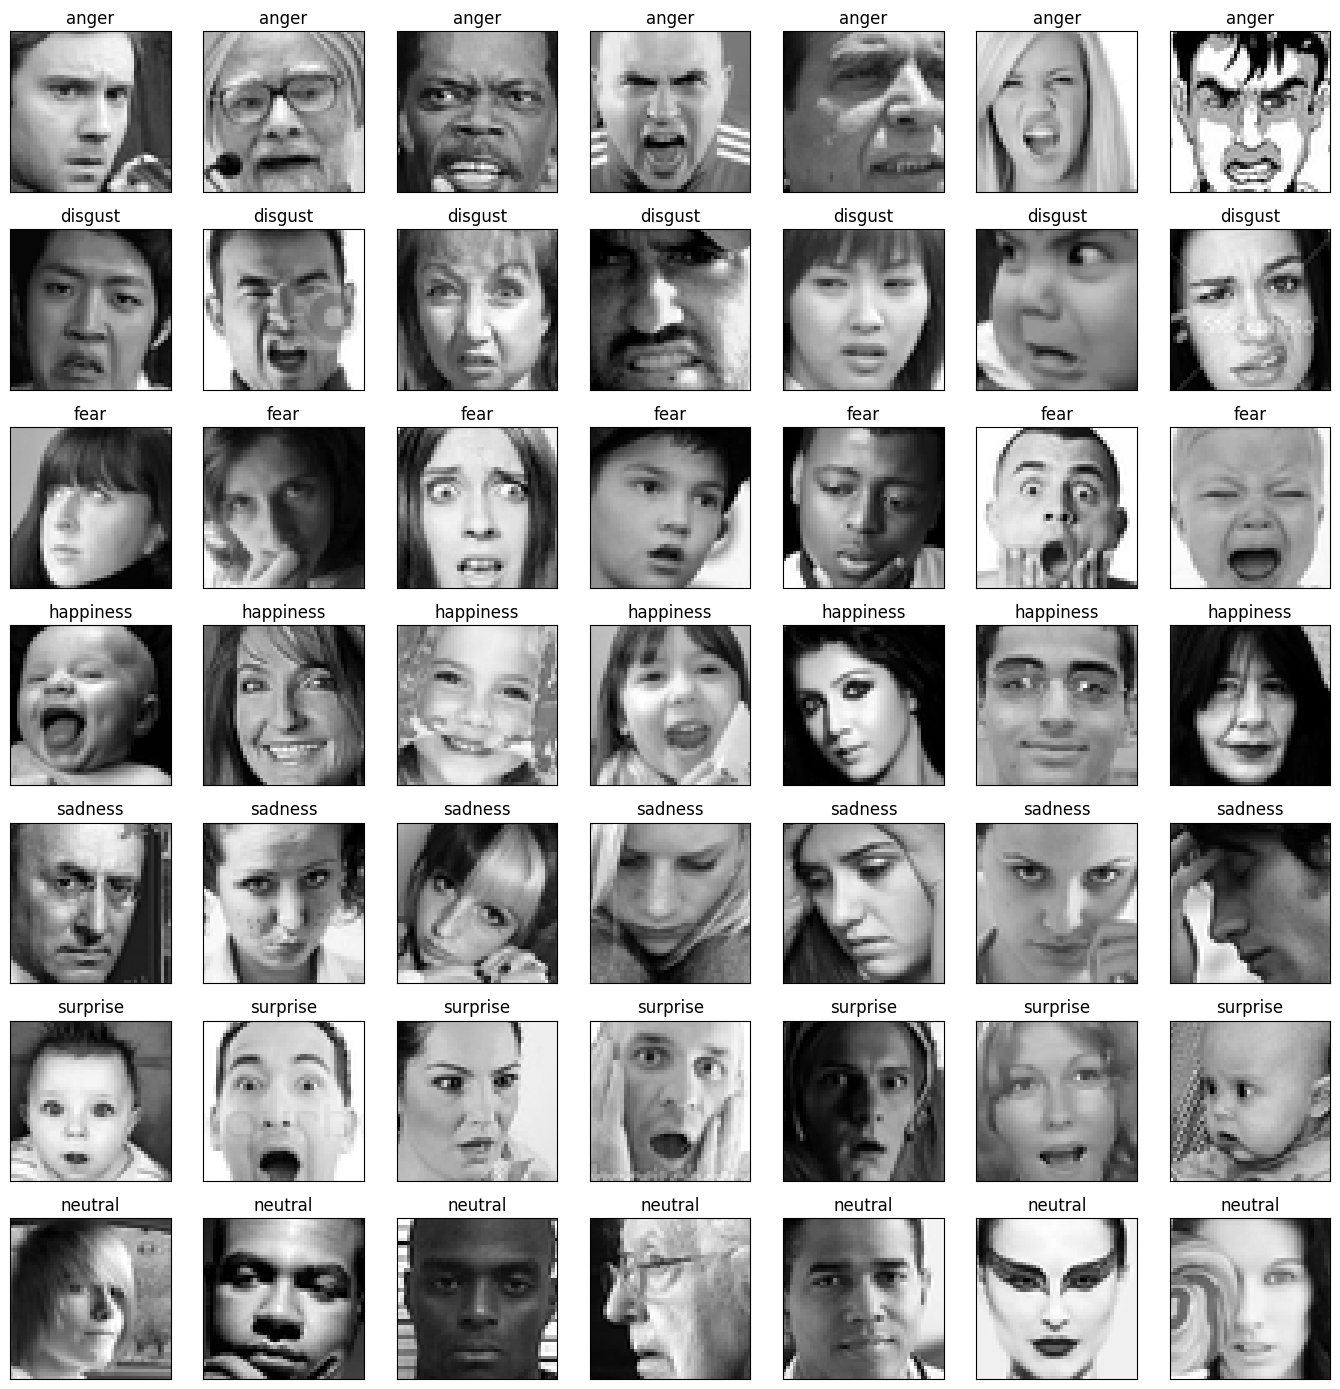

In [ ]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion == label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [ ]:
df.shape

(35887, 3)

In [ ]:
# Convert the encoded labels to one-hot encoded format
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [ ]:
img_labels[:5]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
# Create a mapping from original class labels to their encoded values
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [ ]:
# Converting a DataFrame column containing image data into a 3D numpy array

# This lambda function takes a string representation of pixel values, splits it into a list of strings,
# converts each string to a float, and then reshapes the list into a 48x48x1 numpy array.
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))

# Stack the 2D arrays (images) into a single 3D array.
img_array = np.stack(img_array, axis=0)

# https://numpy.org/doc/1.13/reference/generated/numpy.dstack.html

In [ ]:
img_array.shape

(35887, 48, 48, 1)

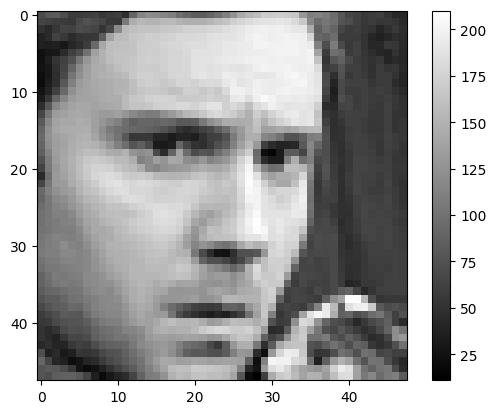

In [ ]:
# Display, for example, the first image
image_to_display = img_array[0]

pyplot.imshow(image_to_display, cmap='gray')
pyplot.colorbar()
pyplot.show()

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle = True, stratify = img_labels,
                                                    test_size = 0.2, random_state = 42)

In [ ]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((28709, 48, 48, 1), (7178, 48, 48, 1), (28709, 7), (7178, 7))

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

#### Compute class weight

In [ ]:

# X = df.drop(['emotion'], axis=1).values
# y = df['emotion'].values

# # Splitting the data
# X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X, y, test_size=0.2, random_state=42)

# # Convert class labels to categorical format for neural network compatibility
# y_train_w_cat = to_categorical(y_train_w)
# y_test_w_cat = to_categorical(y_test_w)

# # Revert y_train_w and y_test_w to their original integer form for class weight computation
# y_train_w = np.argmax(y_train_w_cat, axis=1)
# y_test_w = np.argmax(y_test_w_cat, axis=1)

# # Compute class weights with named arguments
# weights = class_weight.compute_class_weight(
#     class_weight="balanced",
#     classes=np.unique(y_train_w),
#     y=y_train_w
# )

# # Convert weights to a dictionary for easier use
# weights_dict = dict(zip(np.unique(y_train_w), weights))



# # Print the class weights
# print(weights_dict)

In [ ]:
# # Create a list of pairs (emotion, weight) using text labels
# emotion_weights = [(emotion_label_to_text[key], value) for key, value in weights_dict.items()]

# # Getting numeric keys from the emotion_label_to_text dictionary
# numeric_keys = list(emotion_label_to_text.keys())

# # Sort the list by numeric keys
# emotion_weights.sort(key=lambda x: numeric_keys[list(emotion_label_to_text.values()).index(x[0])])

# # We divide the data into two lists to build a graph
# labels, values = zip(*emotion_weights)

# pyplot.figure(figsize=(10, 6))
# pyplot.bar(labels, values)
# # pyplot.xlabel('Emotions / эмоции')
# pyplot.ylabel('Weights / веса')
# pyplot.title('Weights Distribution Emotions / Распределение весов эмоций')
# pyplot.xticks(rotation=45)
# pyplot.tight_layout()
# pyplot.show()

#### Oversampling

In [ ]:
# Flatten the image array
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Each image becomes a vector of length 48*48=2304


In [ ]:
# Explicitly check the number of samples in X_train_flat and y_train
num_samples_X_train_flat = X_train_flat.shape[0]
num_samples_y_train = y_train.shape[0]

In [ ]:
if num_samples_X_train_flat!= num_samples_y_train:
    raise ValueError(f"Mismatch in the number of samples: {num_samples_X_train_flat} vs {num_samples_y_train}")

In [ ]:

# Apply SMOTE for oversampling
smote = SMOTE(
    sampling_strategy = 'auto',
    random_state = 42,
    k_neighbors = 6,
    n_jobs = 1
)

In [ ]:
X_resampled, y_resampled = smote.fit_resample(X_train_flat, y_train)

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [ ]:
# Reshape X_resampled back to its original dimension for model training
X_resampled = X_resampled.reshape(-1, 48, 48, 1)

In [ ]:
y_resampled = y_resampled.astype(np.float32)

In [ ]:
y_resampled[1]

array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)

### Step 3: Define and Train the Model
Define a CNN model for emotion detection and train it on the FER2013 dataset.

In [ ]:
def create_cnn_model(input_shape = (48, 48, 1)):
    model = Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='elu', padding = "same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3, 3), activation='elu', padding = "same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(128, (3, 3), activation='elu', padding = "same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(512, (3, 3), activation='elu', padding = "same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2,2)))
    model.add(Dropout(0.1))

    model.add(Flatten())
    model.add(Dense(256, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(128, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(64, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))


    model.add(Dense(7, activation = 'softmax')) # 7 emotions
    return model


In [ ]:
# Create the model
model = create_cnn_model()

# Compile the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy','Precision','Recall'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 64)        2

In [ ]:
print("X_resampled shape:", X_resampled.shape)
print("X_resampled dtype:", X_resampled.dtype)
print("y_resampled shape:", y_resampled.shape)
print("y_resampled dtype:", y_resampled.dtype)

X_resampled shape: (50337, 48, 48, 1)
X_resampled dtype: float32
y_resampled shape: (50337, 7)
y_resampled dtype: float32


In [ ]:
print("Size of X_resampled:", X_resampled.size)
print("Size of y_resampled:", y_resampled.size)
print("Size of X_train:", X_train.size)
print("Size of y_train:", y_train.size)


Size of X_resampled: 115976448
Size of y_resampled: 352359
Size of X_train: 66145536
Size of y_train: 200963


In [ ]:
type(y_resampled), y_resampled[1], y_resampled.dtype

(numpy.ndarray,
 array([0., 0., 0., 0., 0., 0., 1.], dtype=float32),
 dtype('float32'))

In [ ]:
# Set up early stopping and model checkpointing
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.00005, patience = 11, restore_best_weights = True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor = 0.5, patience = 7, min_lr = 1e-7)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/diploma/data/CNN_smote_elu.keras', monitor = 'val_loss', save_best_only = True, mode = 'min')


In [ ]:
# Train the model with resampled data and class weights
history = model.fit(X_resampled,
                    y_resampled,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_valid, y_valid),
                    # class_weight=weights_dict,
                    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
                   )

Epoch 1/50
1574/1574 [==============================] - 33s 14ms/step - loss: 1.4145 - accuracy: 0.4636 - precision: 0.7032 - recall: 0.2694 - val_loss: 1.3500 - val_accuracy: 0.4857 - val_precision: 0.6690 - val_recall: 0.2928 - lr: 0.0010
Epoch 2/50
1574/1574 [==============================] - 21s 13ms/step - loss: 1.0282 - accuracy: 0.6139 - precision: 0.7735 - recall: 0.4610 - val_loss: 1.2455 - val_accuracy: 0.5365 - val_precision: 0.6810 - val_recall: 0.3803 - lr: 0.0010
Epoch 3/50
1574/1574 [==============================] - 20s 13ms/step - loss: 0.8546 - accuracy: 0.6851 - precision: 0.7987 - recall: 0.5737 - val_loss: 1.2421 - val_accuracy: 0.5499 - val_precision: 0.6574 - val_recall: 0.4437 - lr: 0.0010
Epoch 4/50
1574/1574 [==============================] - 21s 13ms/step - loss: 0.7159 - accuracy: 0.7419 - precision: 0.8206 - recall: 0.6652 - val_loss: 1.1974 - val_accuracy: 0.5874 - val_precision: 0.6618 - val_recall: 0.5081 - lr: 0.0010
Epoch 5/50
1574/1574 [==============

In [ ]:
# # Load the best model
# model = load_model('/content/drive/MyDrive/diploma/data/CNN_smote_elu.keras')

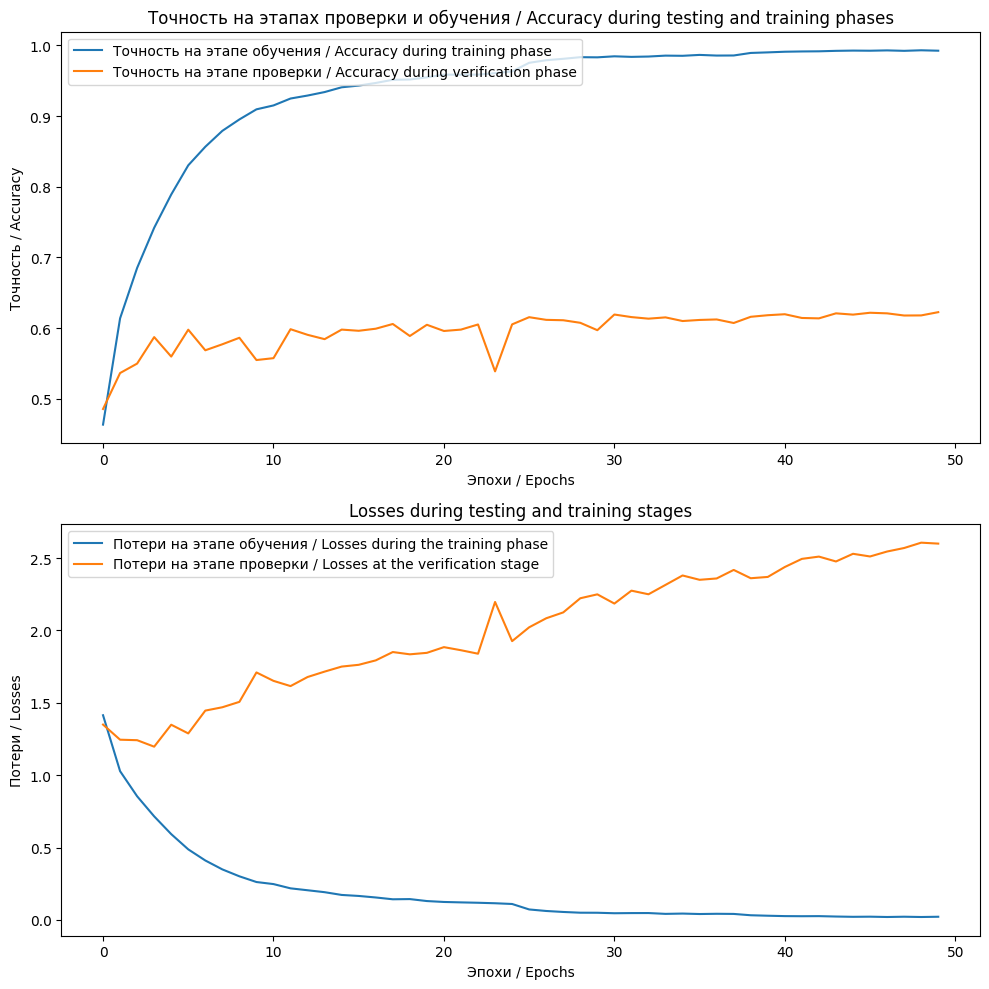

In [ ]:

fig, axs = pyplot.subplots(2, 1, figsize=(10, 10))

# Accuracy / График точности
axs[0].plot(history.history['accuracy'], label='Точность на этапе обучения / Accuracy during training phase')
axs[0].plot(history.history['val_accuracy'], label='Точность на этапе проверки / Accuracy during verification phase')
axs[0].set_title('Точность на этапах проверки и обучения / Accuracy during testing and training phases')
axs[0].set_ylabel('Точность / Accuracy')
axs[0].set_xlabel('Эпохи / Epochs')
axs[0].legend(loc='upper left')

# Loss / График потерь
axs[1].plot(history.history['loss'], label='Потери на этапе обучения / Losses during the training phase')
axs[1].plot(history.history['val_loss'], label='Потери на этапе проверки / Losses at the verification stage')
axs[1].set_title('Losses during testing and training stages')
axs[1].set_ylabel('Потери / Losses')
axs[1].set_xlabel('Эпохи / Epochs')
axs[1].legend(loc='upper left')

# Отображаем графики
pyplot.tight_layout()  # Оптимизирует поля и расположение объектов
pyplot.show()

In [ ]:
predictions = model.predict(X_valid)


225/225 [==============================] - 1s 3ms/step


In [ ]:
# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis = 1)


In [ ]:
predicted_classes_one_hot = to_categorical(predicted_classes, num_classes = 7)

# Now, both predicted_classes_one_hot and y_valid are in the same format
report = classification_report(y_valid, predicted_classes_one_hot)
print(report)


              precision    recall  f1-score   support

           0       0.56      0.50      0.53       991
           1       0.84      0.56      0.67       109
           2       0.55      0.47      0.50      1024
           3       0.77      0.82      0.79      1798
           4       0.50      0.49      0.50      1216
           5       0.76      0.76      0.76       800
           6       0.52      0.62      0.57      1240

   micro avg       0.62      0.62      0.62      7178
   macro avg       0.64      0.60      0.62      7178
weighted avg       0.62      0.62      0.62      7178
 samples avg       0.62      0.62      0.62      7178



### Step 4: Implement the Emotion Detection Function
Implement the detect_emotion function using the trained model.

In [ ]:
def detect_emotion(image):
    image = cv2.resize(image, (48, 48))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = np.expand_dims(image, axis=-1)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)
    emotion_index = np.argmax(prediction)

    emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    emotion = emotion_labels[emotion_index]

    return emotion


### Step 5: Integrate Face Detection and Emotion Detection
Integrate the face detection code with the emotion detection fqunction. When an emotion change is detected, save the image, close the camera, and print the detected emotion.

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

device_name = "/dev/video0"
cap = cv2.VideoCapture(device_name, cv2.CAP_V4L2)
cap = cv2.VideoCapture(0)

save_dir = "/content/drive/MyDrive/diploma/data/face_images_weight_2/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

last_emotion = None
emotion_images = []
frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        print("Не удалось прочитать кадр.")
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        face_image = frame[y:y+h, x:x+w]

        current_emotion = detect_emotion(face_image)

        if current_emotion != last_emotion:
            # Draw the emotion label on the face image
            cv2.putText(face_image, current_emotion, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

            # Save the face image with the emotion label
            image_path = os.path.join(save_dir, f"face_{frame_count}.jpg")
            cv2.imwrite(image_path, face_image)

            # Add the emotion image to the list
            emotion_images.append(face_image)
            last_emotion = current_emotion
            frame_count += 1

    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Не удалось прочитать кадр.


Step 2: Plot the Detected Emotions

In [ ]:
# The path to folder containing the images
folder_path = "./content/drive/MyDrive/diploma/data/face_images_weight_2/*.*"

# Use glob to get a list of all image files in the folder
image_files = glob.glob(folder_path)

# Load and resize images
resized_images = [cv2.resize(cv2.imread(img), (64, 64)) for img in image_files]

# Convert the list of resized images to a numpy array
emotion_images_np = np.array(resized_images)

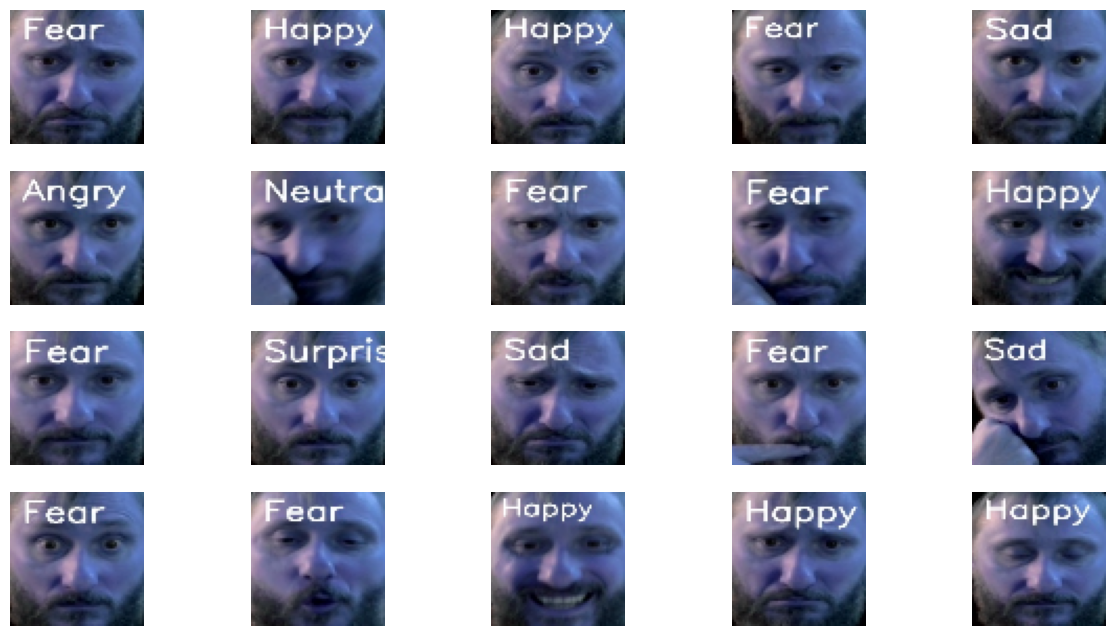

In [ ]:
def plot_image_grid(images, ncols=None, cmap='gray', N=20):
    '''Plot a grid of images without emotion labels'''
    # Check if images is empty or has fewer elements than N
    if images.size == 0 or images.shape[0] < N:
        N = images.shape[0] # Adjust N to the number of available images
        if N == 0: # If images is empty, skip the rest of the function
            print("No images to display.")
            return

    # Ensure images is a 1-dimensional array of indices
    indices = np.arange(images.shape[0])
    selected_indices = np.random.choice(indices, size=N, replace=False)

    if not ncols:
        factors = [i for i in range(1, len(selected_indices)+1) if len(selected_indices) % i == 0]
        ncols = factors[len(factors) // 2] if len(factors) else len(selected_indices) // 4 + 1
    nrows = int(len(selected_indices) / ncols) + int(len(selected_indices) % ncols)
    imgs = [images[i] if len(images) > i else None for i in selected_indices]
    f, axes = pyplot.subplots(nrows, ncols, figsize=(3*ncols, 2*nrows))
    axes = axes.flatten()[:len(imgs)]
    for img, ax in zip(imgs, axes.flatten()):
        if np.any(img):
            if len(img.shape) > 2 and img.shape[2] == 1:
                img = img.squeeze()
            ax.imshow(img, cmap=cmap)
            ax.axis('off') # Hide axes
    pyplot.show()


plot_image_grid(emotion_images_np, cmap = 'coolwarm')
